In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8,)
%matplotlib inline
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/fake-figs"

log_loc = os.path.abspath("/Users/crankshaw/clipper/experiments_logs/straggler_mitigation")

results_files = []
for name in os.listdir(log_loc):
    if "results" in name:
        results_files.append(name)

exp_names = [f.split("_results")[0] for f in results_files]
# print exp_names
print results_files

['ensemble_size_10_160914-004737_results.json', 'ensemble_size_12_160914-005036_results.json', 'ensemble_size_14_160914-005340_results.json', 'ensemble_size_16_160914-005656_results.json', 'ensemble_size_18_160914-010028_results.json', 'ensemble_size_1_160914-003301_results.json', 'ensemble_size_20_160914-010351_results.json', 'ensemble_size_2_160914-003553_results.json', 'ensemble_size_4_160914-003847_results.json', 'ensemble_size_6_160914-004142_results.json', 'ensemble_size_8_160914-004438_results.json']


In [27]:

def extract_results(i, df, fname):
    with open(os.path.join(log_loc, fname), "r") as f:
        ensemble_size = int(fname.split("_")[2])
#         print fname
        res = json.load(f)
        clipper_p99 = [m["p99"] for m in res["histograms"] if "prediction_latency" in m["name"]][0]
        blocking_p99 = [m["p99"] for m in res["histograms"] if "straggler_blocking_prediction_latency" in m["name"]][0]
        clipper_mean = [m["mean"] for m in res["histograms"] if "prediction_latency" in m["name"]][0]
        blocking_mean = [m["mean"] for m in res["histograms"] if "straggler_blocking_prediction_latency" in m["name"]][0]
        if ensemble_size < 18:
            df.loc[i] = [ensemble_size, clipper_mean, clipper_p99, blocking_mean, blocking_p99]

df = pd.DataFrame(columns=("ensemble_size", "clipper_mean_lat", "clipper_p99", "blocking_mean_lat", "blocking_p99"))
[extract_results(i, df, r) for (i,r) in enumerate(results_files)]
# for r in results_files:
#     extract_results(i, df, r)

[None, None, None, None, None, None, None, None, None, None, None]

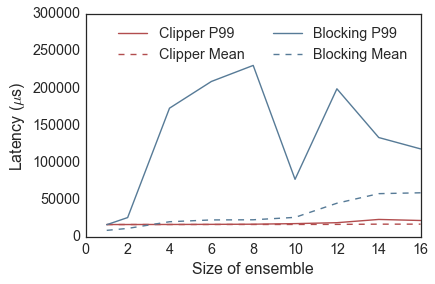

In [38]:
df.sort_values("ensemble_size", inplace=True)
colors = sns.color_palette("Set1", n_colors=8, desat=.5)

fig, ax = plt.subplots()
ax.plot(df["ensemble_size"], df["clipper_p99"], color=colors[0], label = "Clipper P99")
ax.plot(df["ensemble_size"], df["clipper_mean_lat"], color=colors[0], linestyle="--", label = "Clipper Mean")
ax.plot(df["ensemble_size"], df["blocking_p99"], color=colors[1], label = "Blocking P99")
ax.plot(df["ensemble_size"], df["blocking_mean_lat"], color=colors[1], linestyle="--", label = "Blocking Mean")
ax.legend(loc=0, ncol=2)
ax.set_ylim(0, 300000)
# ax.set_yscale("log")
ax.set_ylabel("Latency ($\mu$s)")
ax.set_xlabel("Size of ensemble")

